In [1]:
import copy
import matplotlib
import pandas
import warnings
import requests
import scipy
from scipy import stats
import subprocess
import numpy as np
import numpy
from matplotlib import pyplot as plt
import json
import seaborn
import networkx as nx
import curatorbin

In [2]:
task_id = "performance_linux_wt_standalone_genny_scale_InsertRemove_26331b9c3917b506edfb42b8caf6e1d26f0958a1_21_08_09_18_58_06"
metric_name = "InsertRemoveTest.Remove"
task_id_compare = "performance_linux_wt_standalone_genny_scale_InsertRemove_ce4344a36a54d02ccf99e2a7f90a4fec58b6c16c_21_08_09_19_15_22"
metric_name_compare = "InsertRemoveTest.Remove"

In [3]:
task_record = requests.get(f"https://cedar.mongodb.com/rest/v1/perf/task_id/{task_id}").json()
task_record_compare = requests.get(f"https://cedar.mongodb.com/rest/v1/perf/task_id/{task_id_compare}").json()

In [4]:
tests = [t for t in task_record if metric_name in t["info"]["test_name"]]
tests_compare = [t for t in task_record_compare if metric_name in t["info"]["test_name"]]

In [5]:
if len(tests) == 0:
    raise ValueError("The metric requested does not exist")

metric_record = tests[0]
metric_record_compare = tests_compare[0]

In [6]:
def get_data(result):
    r = requests.get(result["artifacts"][0]["download_url"])
    with open(f"{metric_name}.ftdc", "wb") as f:
        f.write(r.content)
    try:
        subprocess.check_call(f"rm {metric_name}.csv", shell=True)
    except:
        pass
    curatorbin.run_curator("ftdc", "export", "csv", "--input", f"{metric_name}.ftdc", "--output", f"{metric_name}.csv")
    df = pandas.read_csv(f"./{metric_name}.csv")
    return df

In [7]:
data = get_data(metric_record)
data_compare = get_data(metric_record_compare)

In [8]:
def data_diffs(data):
    for field in ["counters.n", "counters.ops", "counters.size", "counters.errors", "timers.dur", "timers.total"]:
        data[field] = data[field].diff().fillna(data[field])
    for field in ["timers.dur", "timers.total"]:
        data[field] = data[field] / 1e+9
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        data["ts"] = pandas.to_datetime(data["ts"])
        data["ts"] = data["ts"] - data["ts"][0]


In [9]:
data_diffs(data)
data_diffs(data_compare)

In [10]:
a = pandas.DataFrame()
a["throughput"] = data.groupby("ts").count()["id"]
a["throughput_compare"] = data_compare.groupby("ts").count()["id"]
a["latency"] = data.groupby("ts").mean()["timers.dur"]
a["latency_compare"] = data_compare.groupby("ts").mean()["timers.dur"]
a["latency-median"] = data.groupby("ts").median()["timers.dur"]
a["latency-median_compare"] = data_compare.groupby("ts").median()["timers.dur"]
a["latency-95th"] = data.groupby("ts").quantile(.95)["timers.dur"]
a["latency-95th_compare"] = data_compare.groupby("ts").quantile(.95)["timers.dur"]
a["latency-max"] = data.groupby("ts").max()["timers.dur"]
a["latency-max_compare"] = data_compare.groupby("ts").max()["timers.dur"]

array([<AxesSubplot:xlabel='ts'>, <AxesSubplot:xlabel='ts'>,
       <AxesSubplot:xlabel='ts'>, <AxesSubplot:xlabel='ts'>,
       <AxesSubplot:xlabel='ts'>, <AxesSubplot:xlabel='ts'>,
       <AxesSubplot:xlabel='ts'>, <AxesSubplot:xlabel='ts'>,
       <AxesSubplot:xlabel='ts'>, <AxesSubplot:xlabel='ts'>], dtype=object)

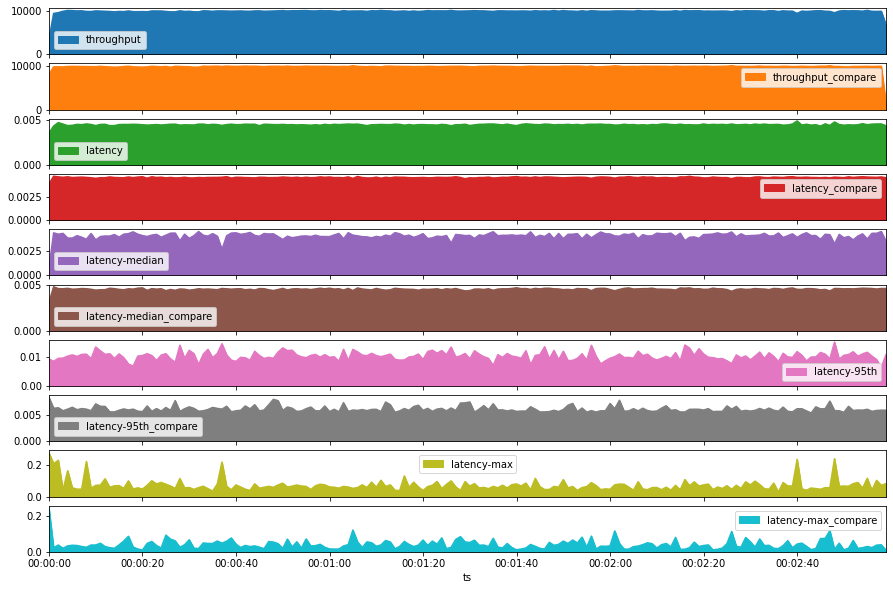

In [11]:
a.plot.area(figsize=(15,10), subplots=True)